In [25]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model,Input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [3]:
y_val = to_categorical(y_val)

In [4]:
input_shape = X_val[0,:,:,:].shape
model_input = Input(shape=input_shape)

**Xception**

In [5]:
xception = Xception(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

2022-04-09 11:07:21.194300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 11:07:21.292584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 11:07:21.293357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 11:07:21.294909: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
for layer in xception.layers:
    layer.trainable = True

In [7]:
xception_last_layer = xception.get_layer('block14_sepconv2_act')
print('last layer output shape:', xception_last_layer.output_shape)
xception_last_output = xception_last_layer.output

last layer output shape: (None, 6, 8, 2048)


In [8]:
# Flatten the output layer to 1 dimension
x_xception = layers.GlobalMaxPooling2D()(xception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_xception = layers.Dense(512, activation='relu')(x_xception)
# Add a dropout rate of 0.7
x_xception = layers.Dropout(0.5)(x_xception)
# Add a final sigmoid layer for classification
x_xception = layers.Dense(7, activation='softmax')(x_xception)

# Configure and compile the model

xception_model = Model(model_input, x_xception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
xception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
xception_model.load_weights('../input/models/Models/xception.h5')

In [10]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

**DenseNet**

In [11]:
denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [12]:
for layer in denseNet.layers:
    layer.trainable = True

In [13]:
denseNet_last_layer = denseNet.get_layer('relu')
print('last layer output shape:', denseNet_last_layer.output_shape)
denseNet_last_output = denseNet_last_layer.output

last layer output shape: (None, 6, 8, 1920)


In [14]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.5)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(7, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
denseNet_model.load_weights("../input/models/Models/DenseNet.h5")

In [16]:
denseNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
____________________________________________________________________________________________

**InceptionV3**

In [17]:
inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [18]:
for layer in inception.layers:
    layer.trainable = True

In [19]:
inception_last_layer = inception.get_layer('mixed10')
print('last layer output shape:', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [20]:
# Flatten the output layer to 1 dimension
x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_inception = layers.Dense(512, activation='relu')(x_inception)
# Add a dropout rate of 0.7
x_inception = layers.Dropout(0.5)(x_inception)
# Add a final sigmoid layer for classification
x_inception = layers.Dense(7, activation='softmax')(x_inception)

# Configure and compile the model

inception_model = Model(model_input, x_inception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
inception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
inception_model.load_weights("../input/models/Models/InceptionV3.h5")

In [22]:
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 95, 127, 32)  96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

**ResNet50**

In [ ]:
resnet = ResNet50(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [ ]:
for layer in resnet.layers:
    layer.trainable = True

In [ ]:
resnet_last_layer = resnet.get_layer('conv5_block3_out')
print('last layer output shape:', resnet_last_layer.output_shape)
resnet_last_output = resnet_last_layer.output

In [ ]:
# Flatten the output layer to 1 dimension
x_resnet = layers.GlobalMaxPooling2D()(resnet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_resnet = layers.Dense(512, activation='relu')(x_resnet)
# Add a dropout rate of 0.7
x_resnet = layers.Dropout(0.5)(x_resnet)
# Add a final sigmoid layer for classification
x_resnet = layers.Dense(7, activation='softmax')(x_resnet)

# Configure and compile the model

resnet_model = Model(model_input, x_resnet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
resnet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
resnet_model.load_weights("../input/models/Models/ResNet.h5")

In [ ]:
resnet_model.summary()

**Vgg16**

In [ ]:
vgg16 = VGG19(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [ ]:
for layer in vgg16.layers:
    layer.trainable = True

In [ ]:
vgg_last_layer = vgg16.get_layer('block5_pool')
print('last layer output shape:', vgg_last_layer.output_shape)
vgg_last_output = vgg_last_layer.output

In [ ]:
# Flatten the output layer to 1 dimension
x_vgg = layers.GlobalMaxPooling2D()(vgg_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_vgg = layers.Dense(512, activation='relu')(x_vgg)
# Add a dropout rate of 0.7
x_vgg = layers.Dropout(0.5)(x_vgg)
# Add a final sigmoid layer for classification
x_vgg = layers.Dense(7, activation='softmax')(x_vgg)

# Configure and compile the model

vgg_model = Model(model_input, x_vgg)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
vgg_model.load_weights("../input/models/Models/vgg16.h5")

In [ ]:
vgg_model.summary()

**EfficientNet**

In [27]:
efficientNet=tf.keras.applications.EfficientNetB4(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [28]:
for layer in efficientNet.layers:
    layer.trainable = True

In [29]:
last_layer = efficientNet.get_layer('top_activation')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1792)


In [33]:
# Flatten the output layer to 1 dimension
x_eff = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_eff = layers.Dense(512, activation='relu')(x_eff)
# Add a dropout rate of 0.5
x_eff = layers.Dropout(0.5)(x_eff)
# Add a final sigmoid layer for classification
x_eff = layers.Dense(7, activation='softmax')(x_eff)

eff_model = Model(efficientNet.input, x_eff)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
eff_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [36]:
eff_model.load_weights("../input/../input/efficientb4/EfficientNetB4.h5")

In [37]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [38]:
ensemble_model = ensemble([inception_model, xception_model, eff_model], model_input)

In [39]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [40]:
loss_val, acc_val = ensemble_model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

2022-04-09 11:11:30.544761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-09 11:11:38.193943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


29/29 [==============================] - 20s 223ms/step - loss: 0.3693 - accuracy: 0.8880
Validation: accuracy = 0.888027  ;  loss_v = 0.369282


In [41]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

y_test = to_categorical(y_test)


In [42]:
loss_test, acc_test = ensemble_model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 7s 226ms/step - loss: 0.3842 - accuracy: 0.8842
Test: accuracy = 0.884232  ;  loss = 0.384213


In [43]:
ensemble_model.save("./Ensemble_incep_dense_eff.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [44]:
y_pred=ensemble_model.predict_generator(X_test)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
K.int_shape(y_pred)

(1002, 7)

In [46]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 13   1  11   1   1   0   1]
 [  1  39  11   0   5   0   1]
 [  1   0  87   0  11   0   9]
 [  0   0   1  13   1   0   0]
 [  0   1  13   0 653   1  10]
 [  0   0   0   1   0  13   0]
 [  0   0  11   1  22   0  68]]


In [47]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.46      0.60        28
     class 1       0.95      0.68      0.80        57
     class 2       0.65      0.81      0.72       108
     class 3       0.81      0.87      0.84        15
     class 4       0.94      0.96      0.95       678
     class 5       0.93      0.93      0.93        14
     class 6       0.76      0.67      0.71       102

    accuracy                           0.88      1002
   macro avg       0.84      0.77      0.79      1002
weighted avg       0.89      0.88      0.88      1002



In [49]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,y_pred,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Sensitivity: 76.84% specificity 97.03%


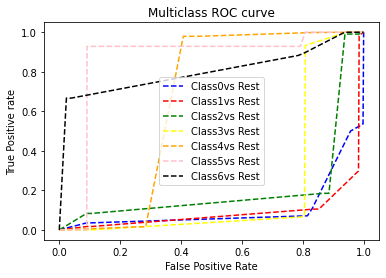

In [50]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);